In [1]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from PIL import Image
from matplotlib.widgets import Slider
import pandas as pd
from tqdm import tqdm
import seaborn as sns
path = '/Volumes/KasiaDrive/Data/20220729'

In [3]:
from scipy.stats import pearsonr

In [4]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Data prep

In [5]:
har800 = 1240/(np.arange(60)[1::2]*(1240/782))
har1800 = 1240/(np.arange(120)[1::2]*(1240/1700))

In [6]:
data = pd.DataFrame(columns = ['wavelength', 'Gas', 'MCP Voltage', 'Exposure time', 'MCP height', 'filter', 'repeat', 'pic'])
#choosing files
files = os.listdir(path)
for file in tqdm(files):
    image = np.array(Image.open(os.path.join(path, file)))
    file = file[:-4]
    wl, g, V, t, h, f, r = file.split('_')
    dic = {'wavelength':wl, 'Gas':g, 'MCP Voltage':V,  'Exposure time':t, 'MCP height':h[6:-2], 'filter':f, 'repeat':r, 'pic':image}
    data = data.append(dic, ignore_index=True)

100%|██████████| 157/157 [01:55<00:00,  1.36it/s]


In [7]:
def wl_calibration(pix_array, coefficient1, coefficient2, height, offset_coeff):
    offset = height*offset_coeff
    return (pix_array-offset)*coefficient1+coefficient2

In [8]:
Al = pd.read_csv('200nm_Al_transmission.txt', delimiter="	",skiprows=1)
Al = Al.drop(Al.columns[-2:], axis = 1)
Al['wl'] = 1240/Al['Photon Energy (eV)']

Zr = pd.read_csv('100nm_Zr_transmission.txt', delimiter="	",skiprows=1)
Zr = Zr.drop(Zr.columns[-2:], axis = 1)
Zr['wl'] = 1240/Zr['Photon energy (eV)']
AlO = pd.read_csv('20nm_O_transmission_1pt5_times_Al_density.txt', delimiter="	",skiprows=1)
AlO = AlO.drop(AlO.columns[-2:], axis = 1)
AlO['wl'] = 1240/AlO['Photon Energy (eV)']

In [9]:
data['line'] = data.apply(lambda row: np.mean(row.pic[800:2800, 560:3700], axis=0), axis=1)

In [10]:
data[(data['wavelength']=='1800nm')*(data['MCP height']=='7')]

/Users/kasia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


,wavelength,Gas,MCP Voltage,Exposure time,MCP height,filter,repeat,pic,line
51,1800nm,Argon300mbar,MCP1650V,2000ms,7,0empty,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[37.257, 36.978, 37.1285, 37.1785, 37.065, 37...."
52,1800nm,Argon300mbar,MCP1650V,2000ms,7,0empty,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[37.876, 37.78, 37.9455, 37.9115, 37.7185, 37...."
53,1800nm,Argon300mbar,MCP1650V,2000ms,7,0empty,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[37.4675, 37.407, 37.3855, 37.614, 37.421, 37...."
54,1800nm,Argon300mbar,MCP1650V,2000ms,7,120Al,1,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[10.809, 10.835, 10.9295, 11.1405, 11.0825, 11..."
55,1800nm,Argon300mbar,MCP1650V,2000ms,7,120Al,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,...","[10.3655, 10.43, 10.471, 10.6155, 10.4675, 10...."
56,1800nm,Argon300mbar,MCP1650V,2000ms,7,120Al,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[10.7915, 10.8, 10.867, 11.032, 10.9665, 11.13..."
57,1800nm,Argon300mbar,MCP1650V,2000ms,7,240Zr,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[13.357, 13.412, 13.4625, 13.759, 13.6755, 14...."
58,1800nm,Argon300mbar,MCP1650V,2000ms,7,240Zr,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[13.357, 13.412, 13.4625, 13.759, 13.6755, 14...."
59,1800nm,Argon300mbar,MCP1650V,2000ms,7,240Zr,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[22.5425, 22.584, 22.7305, 22.969, 22.751, 22...."
60,1800nm,Argon300mbar,MCP1650V,2000ms,7,300p3ht,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0745, 0.08, 0.066, 0.1975, 0.0595, 0.327, 0..."


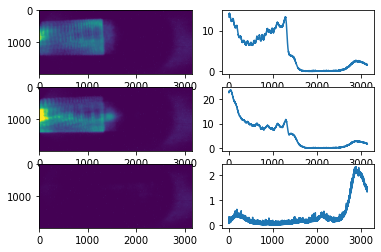

In [19]:
fig, ax = plt.subplots(3, 2)
ax = ax.flatten()

ax[0].imshow(data['pic'][57][800:2800, 560:3700], vmax = 60, aspect='auto')
ax[2].imshow(data['pic'][59][800:2800, 560:3700], vmax = 60, aspect='auto')
ax[4].imshow(data['pic'][60][800:2800, 560:3700], vmax = 60, aspect='auto')
ax[1].plot(np.mean(data['pic'][57][800:2800, 560:3700], axis=0))
ax[3].plot(np.mean(data['pic'][59][800:2800, 560:3700], axis=0))
ax[5].plot(np.mean(data['pic'][60][800:2800, 560:3700], axis=0))


In [12]:
df = data.groupby(['wavelength', 'filter', 'Gas', 'MCP Voltage','Exposure time' ,'MCP height']).apply(lambda row: np.mean(row.line))

In [13]:
count = 0 
for k in df.keys():
    print(count, k)
    count +=1

0 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '1000ms', '0')
1 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '1')
2 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '3')
3 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '5')
4 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '6')
5 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '7')
6 ('1800nm', '120Al', 'Argon300mbar', 'MCP1650V', '2000ms', '7')
7 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '1')
8 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '3')
9 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '5')
10 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '6')
11 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '1')
12 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '3')
13 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '5')
14 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '6')
15 ('1800nm', 

In [20]:
def clean_data(idx, lam = 100000, p = 0.0005):
    if idx in [21,22,23,31,33,34,35,39,40,41,49,50,53]:
        bg = 53
    elif idx in [0,24,25,26,27,28,29,30,32,36,37,38,42,43,44,45,46,47,48,51,52,54]:
        bg = 54
    elif idx in np.arange(1,21):
        bg = 7
    y = df[idx] - bg
    z = baseline_als(y, lam, p)
    return y-z



In [21]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

## Checking filter data

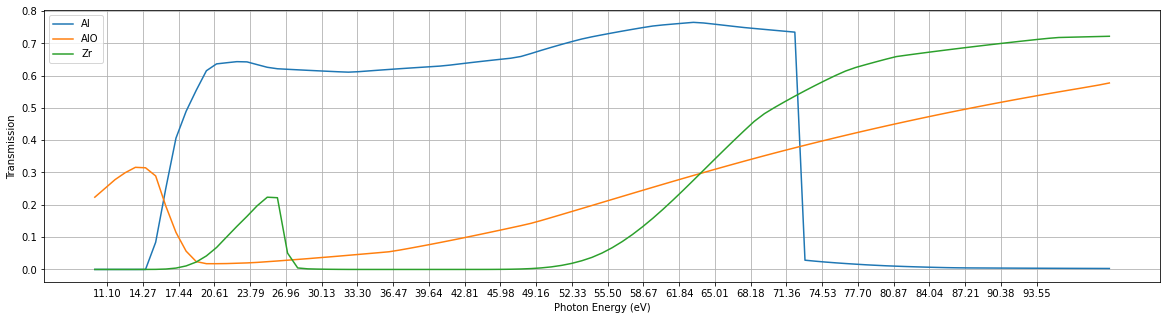

In [22]:
plt.figure(figsize=(20,5))
sns.lineplot(data=Al, x = Al.columns[0], y = Al.columns[1], label = 'Al')
sns.lineplot(data=AlO, x = Al.columns[0], y = Al.columns[1], label = 'AlO')
sns.lineplot(data=Zr, x = Zr.columns[0], y = Zr.columns[1], label = 'Zr')
plt.xticks(1240/har800[(har800>10)*(har800<120)])
# plt.xticks(1240/har1800[(har1800>10)*(har1800<120)])
plt.grid()
plt.show()

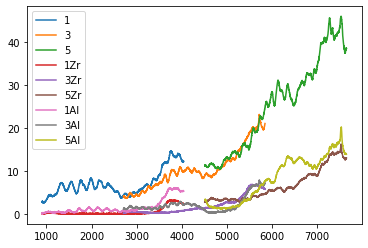

In [24]:
offset = 903
plt.plot(np.arange( len(df[24]))+1*offset,df[1], label='1')
plt.plot(np.arange(len(df[24]))+3*offset,df[2], label='3')
plt.plot(np.arange( len(df[24]))+5*offset,df[3], label='5')

plt.plot(np.arange( len(df[24]))+1*offset,df[7], label='1Zr')
plt.plot(np.arange(len(df[24]))+3*offset,df[8], label='3Zr')
plt.plot(np.arange( len(df[24]))+5*offset,df[9], label='5Zr')


plt.plot(np.arange( len(df[24]))+1*offset,df[11], label='1Al')
plt.plot(np.arange(len(df[24]))+3*offset,df[12], label='3Al')
plt.plot(np.arange( len(df[24]))+5*offset,df[13], label='5Al')

#plt.plot(df[31], label='no gas')
plt.legend()

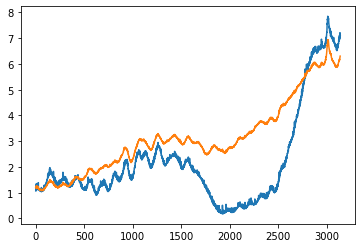

In [25]:
plt.plot(df[12])
plt.plot(df[2]*0.3)


# Working on the offset

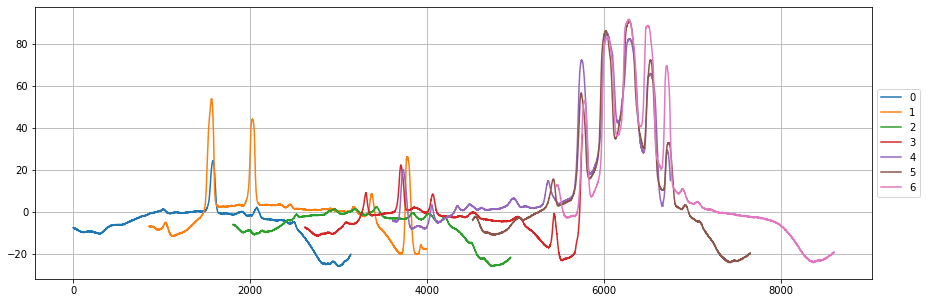

In [119]:
plt.figure(figsize=(15,5))
offset = 903
plt.plot(np.arange(len(df[24]))+0*offset, df[24]-df[31], label = '0')
plt.plot(np.arange(len(df[24]))+0.95*offset, df[25]-df[31], label = '1')
plt.plot(np.arange(len(df[24]))+2*offset, df[26]-df[31], label = '2')
plt.plot(np.arange(len(df[24]))+2.9*offset, df[27]-df[31], label = '3')
plt.plot(np.arange(len(df[24]))+4*offset, df[28]-df[31], label = '4')
plt.plot(np.arange(len(df[24]))+5*offset, df[29]-df[31], label = '5')
plt.plot(np.arange(len(df[24]))+6.05*offset, df[30]-df[31], label = '6')


# plt.xlim(6000,8000)

plt.grid()
plt.legend(loc='center left', bbox_to_anchor = [1,0.5])

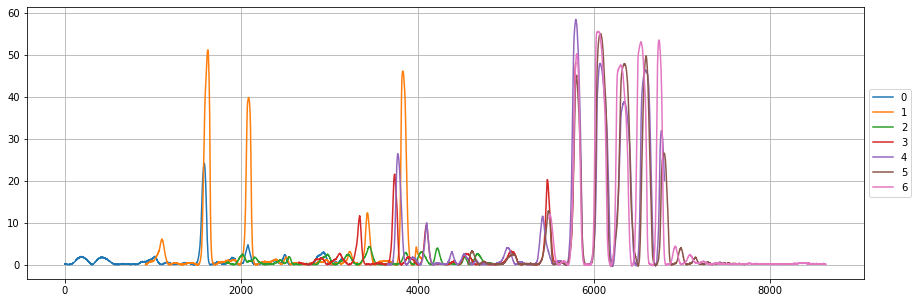

In [120]:
plt.figure(figsize=(15,5))
lam = 10000
p = 0.001
offset = 915
plt.plot(np.arange(len(df[24]))+0*offset, clean_data(24), label = '0')
plt.plot(np.arange(len(df[24]))+1*offset, clean_data(25), label = '1')
plt.plot(np.arange(len(df[24]))+2*offset, clean_data(26), label = '2')
plt.plot(np.arange(len(df[24]))+2.9*offset, clean_data(27), label = '3')
plt.plot(np.arange(len(df[24]))+4*offset, clean_data(28), label = '4')
plt.plot(np.arange(len(df[24]))+5*offset, clean_data(29), label = '5')
plt.plot(np.arange(len(df[24]))+6*offset, clean_data(30), label = '6')

# plt.xlim(5000,8000)
plt.grid()
plt.legend(loc='center left', bbox_to_anchor = [1,0.5])

# Baseline substraction

So we have some background images we can look at

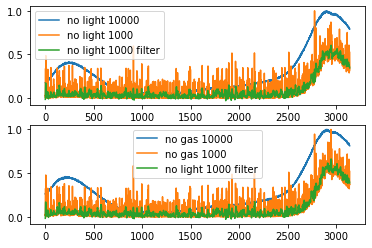

In [121]:
fig, ax = plt.subplots(2)
ax[0].plot(df[53]/max(df[53]), label = 'no light 10000')
ax[0].plot(df[54]/max(df[54]), label = 'no light 1000')
ax[0].plot(savgol_filter(df[54]/max(df[54]),15,3), label = 'no light 1000 filter')
ax[1].plot(df[31]/max(df[31]), label = 'no gas 10000')
ax[1].plot(df[32]/max(df[32]), label = 'no gas 1000')
ax[1].plot(savgol_filter(df[32]/max(df[32]),15,3), label = 'no light 1000 filter')
ax[0].legend()
ax[1].legend()

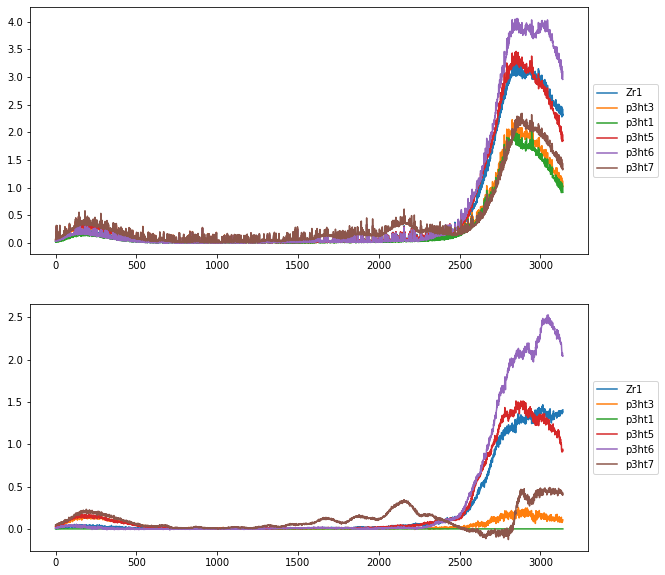

In [122]:
fig, ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(df[7], label='Zr1')
ax[0].plot(df[16], label='p3ht3')
ax[0].plot(df[17], label='p3ht1')
ax[0].plot(df[18], label='p3ht5')
ax[0].plot(df[19], label='p3ht6')
ax[0].plot(df[20], label='p3ht7')

ax[0].legend(loc='center left', bbox_to_anchor=[1,0.5])

ax[1].plot(df[7]-df[17], label='Zr1')
ax[1].plot(df[16]-df[17], label='p3ht3')
ax[1].plot(df[17]-df[17], label='p3ht1')
ax[1].plot(df[18]-df[17], label='p3ht5')
ax[1].plot(df[19]-df[17], label='p3ht6')
ax[1].plot(df[20]-df[17], label='p3ht7')

ax[1].legend(loc='center left', bbox_to_anchor=[1,0.5])

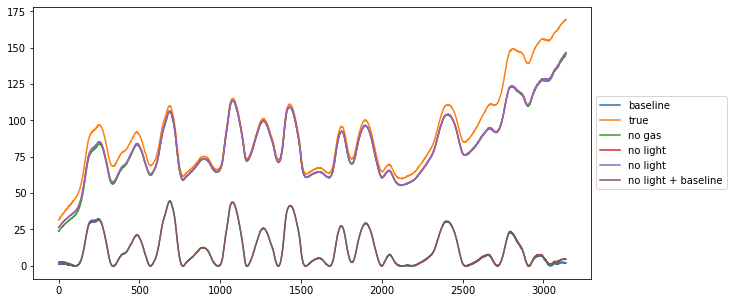

In [123]:
lam = 100000
p = 0.0005
y1 = df[22]
z1 = baseline_als(y1, lam, p)
z_bg = baseline_als(y1-df[53], lam, p)
# plt.plot(np.arange(y1.shape[0]),y1)
n1= 61
n2 = 3
plt.figure(figsize=(10,5))
plt.plot(np.arange(y1.shape[0]),y1-z1 , label = 'baseline')
plt.plot(np.arange(y1.shape[0]), y1, label = 'true')
plt.plot(np.arange(y1.shape[0]), y1-df[31], label = 'no gas')
plt.plot(np.arange(y1.shape[0]), y1-df[53], label = 'no light')
plt.plot(np.arange(y1.shape[0]), y1-df[53], label = 'no light')
plt.plot(np.arange(y1.shape[0]), y1-df[53] - z_bg, label = 'no light + baseline')
plt.legend(loc = 'center left', bbox_to_anchor = [1,0.5])

(0.0, 9.0)

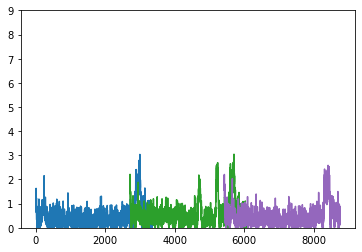

In [101]:
y1 = df[33]
z1 = baseline_als(y1, 10000,0.001)
y2 = df[34]
z2 = baseline_als(y2, 10000,0.001)
y3 = df[35]
z3 = baseline_als(y3, 10000,0.001)
# plt.plot(np.arange(y1.shape[0]),y1)
n1= 61
n2 = 3
plt.plot(np.arange(y1.shape[0]),y1-z1, n1, n2)

plt.plot(np.arange(y1.shape[0])+3*903,y2-z2, n1, n2)

plt.plot(np.arange(y1.shape[0])+6*903,y3-z3, n1, n2)
plt.ylim(0,)

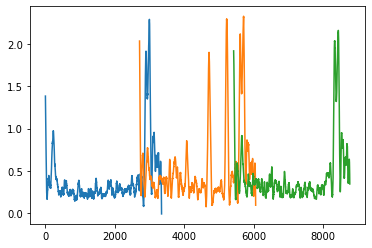

In [95]:
y1 = df[33]
z1 = baseline_als(y1, 10000,0.001)
y2 = df[34]
z2 = baseline_als(y2, 10000,0.001)
y3 = df[35]
z3 = baseline_als(y3, 10000,0.001)
# plt.plot(np.arange(y1.shape[0]),y1)
n1= 61
n2 = 3
plt.plot(np.arange(y1.shape[0]),savgol_filter(y1-z1, n1, n2))
# plt.plot(np.arange(y1.shape[0])+3*903,y2)
plt.plot(np.arange(y1.shape[0])+3*903,savgol_filter(y2-z2, n1, n2))
# plt.plot(np.arange(y1.shape[0])+6*903,y3)
plt.plot(np.arange(y1.shape[0])+6*903,savgol_filter(y3-z3, n1, n2))

# Filter Investigation 800

Offset of 903 gives us best results

(0.0, 8558.0)

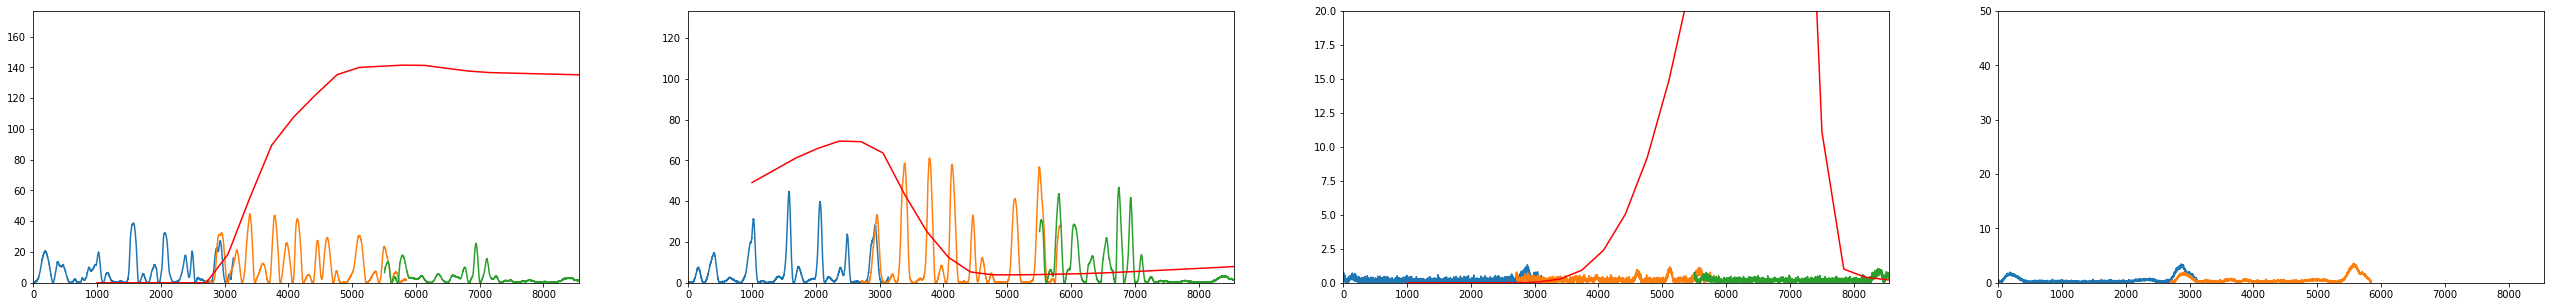

In [19]:
offset = 903
lam = 100000
p = 0.0005
fig, ax = plt.subplots(1,4, figsize=(45,5), sharex=True)
ax[0].plot(np.arange(len(df[24]))+0*offset,clean_data(21))
ax[0].plot(np.arange(len(df[24]))+3*offset,clean_data(22))
ax[0].plot(np.arange(len(df[24]))+6.1*offset,clean_data(23))

ax[1].plot(np.arange(len(df[24]))+0*offset,clean_data(39))
ax[1].plot(np.arange(len(df[24]))+3*offset,clean_data(40))
ax[1].plot(np.arange(len(df[24]))+6.1*offset,clean_data(41))

ax[2].plot(np.arange(len(df[24]))+0*offset,clean_data(33, lam = 10000, p= 0.001))
ax[2].plot(np.arange(len(df[24]))+3*offset,clean_data(34, lam = 10000, p= 0.001))
ax[2].plot(np.arange(len(df[24]))+6.1*offset,clean_data(35, lam = 10000, p=0.001))

ax[3].plot(np.arange(len(df[24]))+0*offset,clean_data(49))
ax[3].plot(np.arange(len(df[24]))+3*offset,clean_data(50))


factor1 = 1000
factor2 = 4
ax[0].plot(factor1+factor2*np.linspace(0, len(df[24])+6*offset, len(Al[Al.columns[1]])), 220*Al[Al.columns[1]], color='r')
ax[1].plot(factor1+factor2*np.linspace(0, len(df[24])+6*offset, len(AlO[AlO.columns[1]])), 220*AlO[AlO.columns[1]], color='r')
ax[2].plot(factor1+factor2*np.linspace(0, len(df[24])+6*offset, len(Zr[Zr.columns[1]])), 220*Zr[Zr.columns[1]], color='r')
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)
ax[2].set_ylim(bottom=0,top =20)
ax[3].set_ylim(bottom=0,top =50)

ax[2].set_xlim(0,len(df[24])+6*offset)

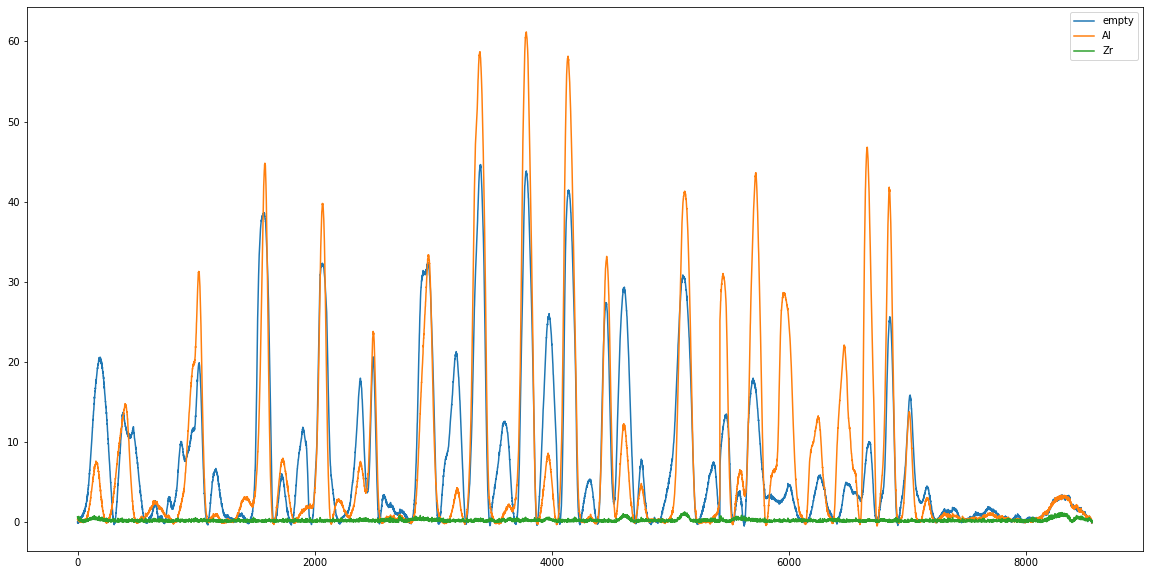

In [20]:
#Making 800 nm data arrays
arr = np.zeros(len(df[24])+6*offset)
y_max = df[24].shape[0]

E800 = arr.copy()
E800[:y_max] = clean_data(21)
E800[3*offset:y_max+3*offset] = clean_data(22)
E800[6*offset:y_max+6*offset] = clean_data(23)

Al800 = arr.copy()
Al800[:y_max] = clean_data(39)
Al800[3*offset:y_max+3*offset] = clean_data(40)
Al800[6*offset:y_max+6*offset] = clean_data(41)

Zr800 = arr.copy()
Zr800[:y_max] = clean_data(33, lam = 15000, p= 0.001)
Zr800[3*offset:y_max+3*offset] = clean_data(34, lam = 15000, p= 0.001)
Zr800[6*offset:y_max+6*offset] = clean_data(35, lam = 15000, p= 0.001)

plt.figure(figsize=(20,10))
plt.plot(E800, label = 'empty')
plt.plot(Al800, label = 'Al')
plt.plot(Zr800, label = 'Zr')
plt.legend()

(5000.0, 9461.0)

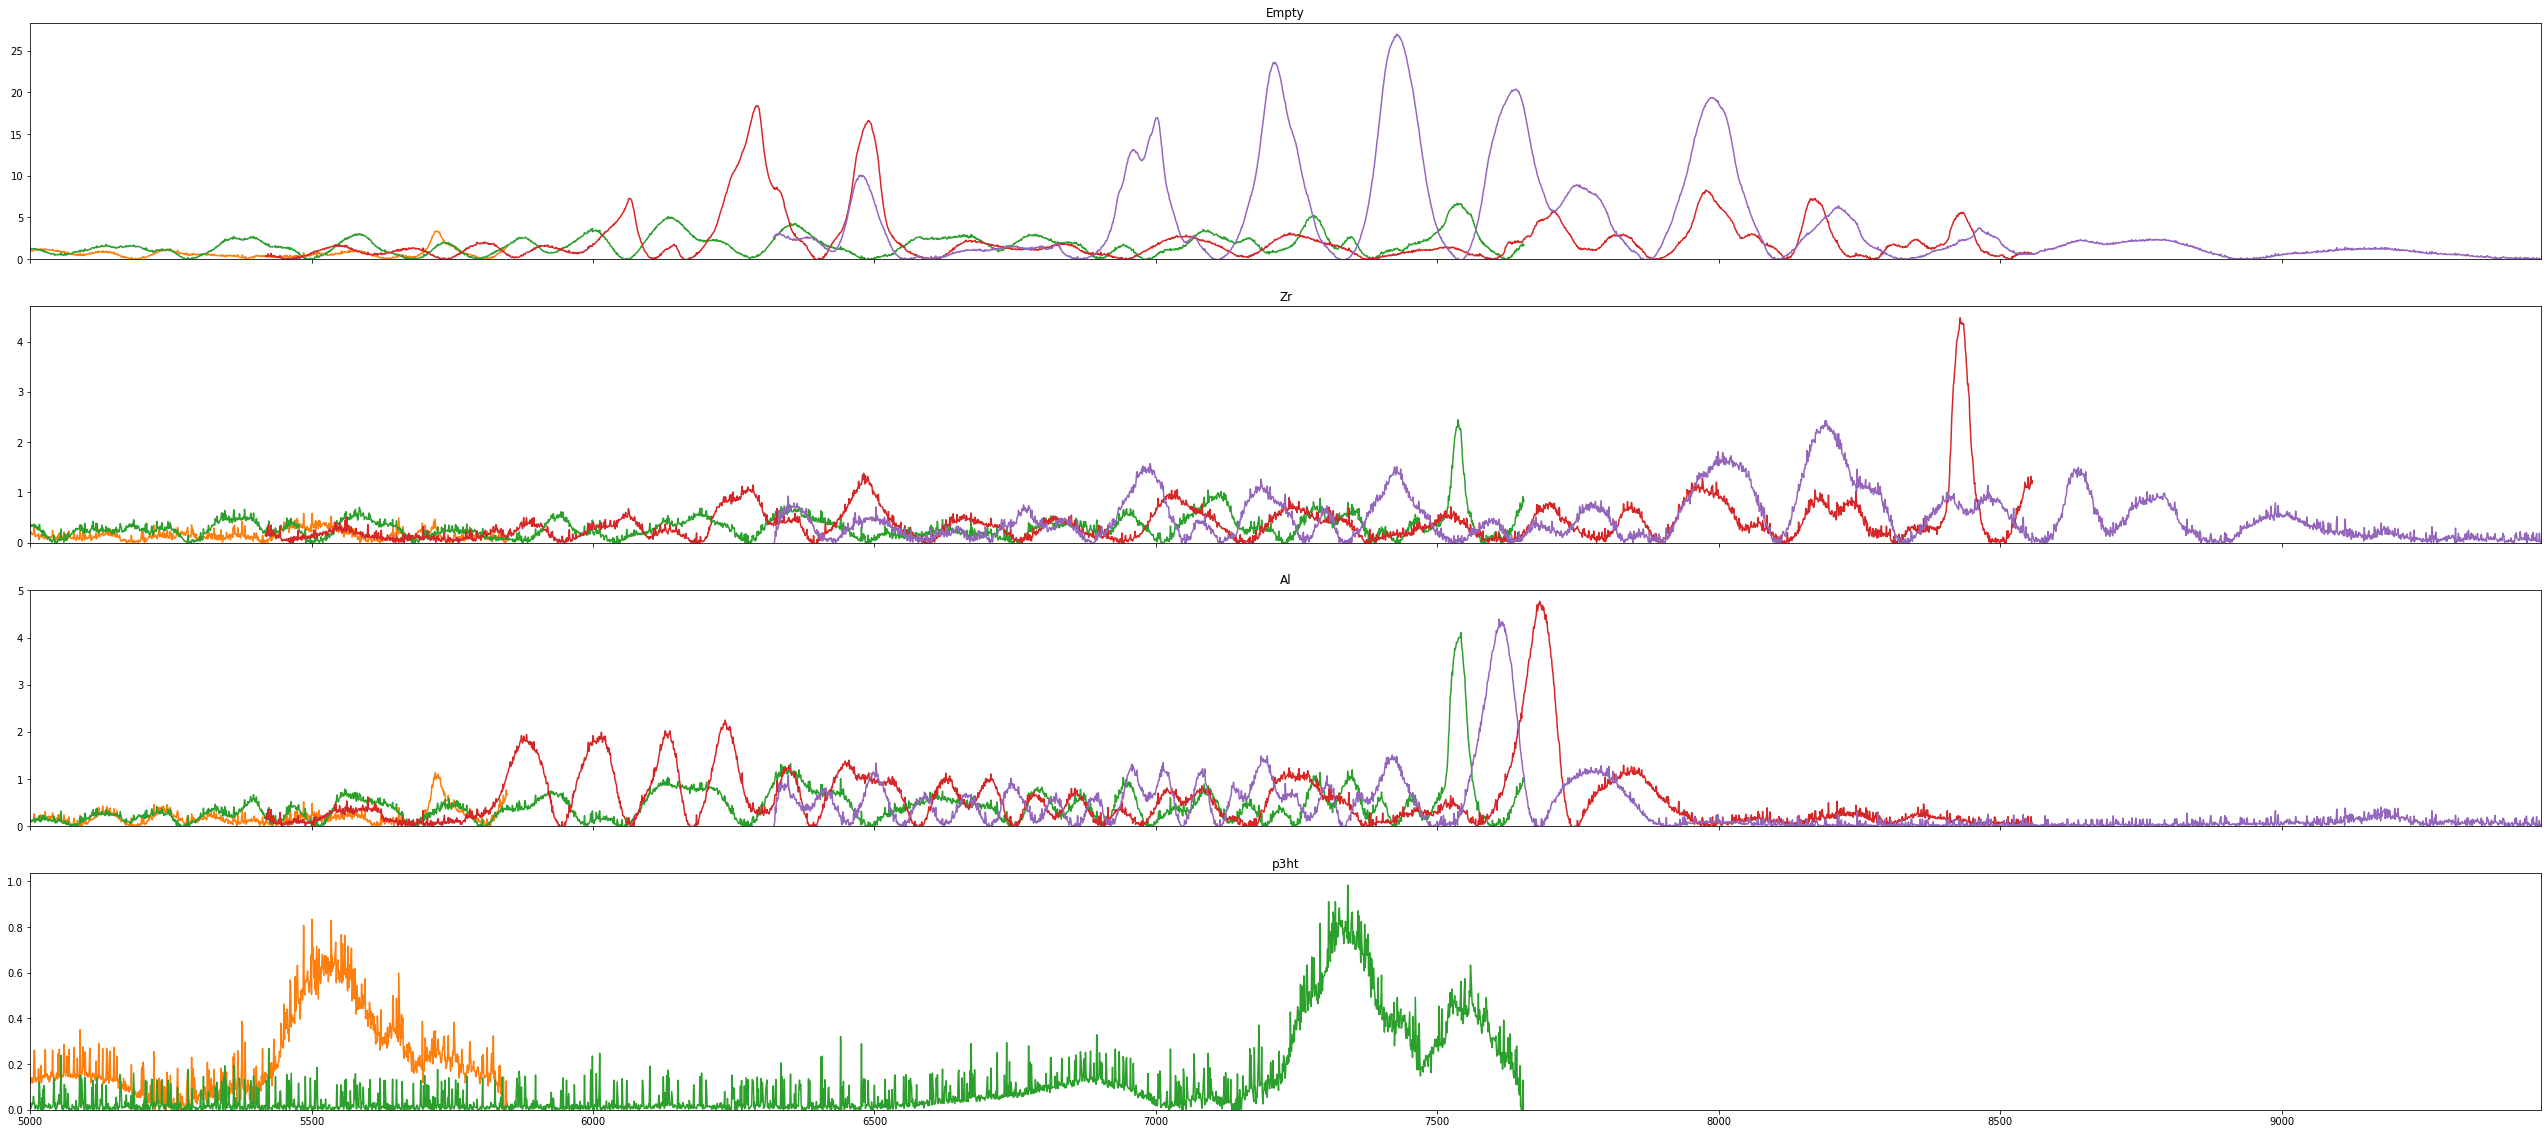

In [21]:
offset = 903
lam = 100
p = 0.01
fig, ax = plt.subplots(4, figsize=(45,20), sharex=True)
ax[0].plot(np.arange(len(df[24]))+1*offset,clean_data(1))
ax[0].plot(np.arange(len(df[24]))+3*offset,clean_data(2))
ax[0].plot(np.arange(len(df[24]))+5*offset,clean_data(3))
ax[0].plot(np.arange(len(df[24]))+6*offset,clean_data(4))
ax[0].plot(np.arange(len(df[24]))+7*offset,clean_data(5))
lam = 10000
p = 0.001
ax[1].plot(np.arange(len(df[24]))+1*offset,clean_data(7, lam, p))
ax[1].plot(np.arange(len(df[24]))+3*offset,clean_data(8, lam, p))
ax[1].plot(np.arange(len(df[24]))+5*offset,clean_data(9, lam, p))
ax[1].plot(np.arange(len(df[24]))+6*offset,clean_data(10, lam, p))
ax[1].plot(np.arange(len(df[24]))+7*offset,clean_data(6, lam, p))

ax[2].plot(np.arange(len(df[24]))+1*offset,clean_data(11, lam, p))
ax[2].plot(np.arange(len(df[24]))+3*offset,clean_data(12, lam, p))
ax[2].plot(np.arange(len(df[24]))+5*offset,clean_data(13, lam, p))
ax[2].plot(np.arange(len(df[24]))+6*offset,clean_data(14, lam, p))
ax[2].plot(np.arange(len(df[24]))+7*offset,clean_data(15, lam, p))

ax[3].plot(np.arange(len(df[24]))+1*offset,clean_data(17))
ax[3].plot(np.arange(len(df[24]))+3*offset,clean_data(18))
ax[3].plot(np.arange(len(df[24]))+5*offset,clean_data(19))


factor1 = 0
factor2 = 2
#ax[0].plot(factor1+factor2*np.linspace(0, len(df[24])+6*offset, len(Al[Al.columns[1]])), 220*Al[Al.columns[1]], color='r')
ax[0].set_ylim(bottom=0)
ax[1].set_ylim(bottom=0)
ax[2].set_ylim(bottom=0)
ax[3].set_ylim(bottom=0)
ax[0].set_title('Empty')
ax[1].set_title('Zr')
ax[2].set_title('Al')
ax[3].set_title('p3ht')
ax[2].set_xlim(5000,len(df[24])+7*offset)

So we can ignore the p3ht

In [22]:
%matplotlib inline

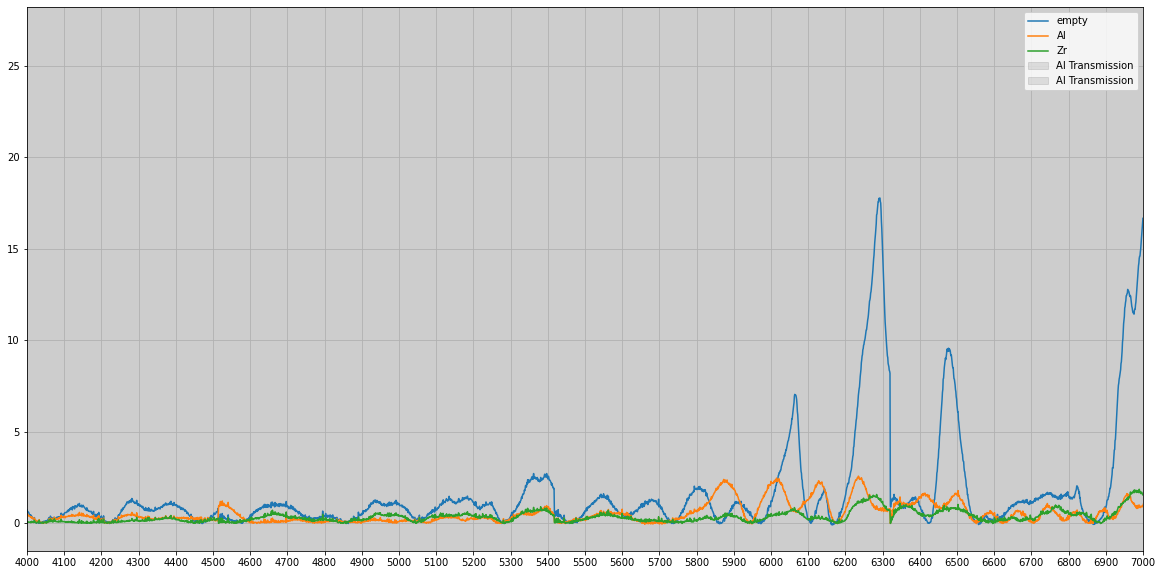

In [23]:
#Making 1800 nm data arrays
offset=903
arr = np.zeros(len(df[24])+7*offset)
y_max = df[24].shape[0]
lam = 10000
p = 0.0001

E1800 = arr.copy()
E1800[1*offset:y_max+1*offset] = clean_data(1, lam, p)
E1800[3*offset:y_max+3*offset] = clean_data(2, lam, p)
E1800[5*offset:y_max+5*offset] = clean_data(3, lam, p)
E1800[6*offset:y_max+6*offset] = clean_data(4, lam, p)
E1800[7*offset:y_max+7*offset] = clean_data(5, lam, p)

Al1800 = arr.copy()
Al1800[1*offset:y_max+1*offset] = clean_data(11, lam, p)
Al1800[3*offset:y_max+3*offset] = clean_data(12, lam, p)
Al1800[5*offset:y_max+5*offset] = clean_data(13, lam, p)
Al1800[6*offset:y_max+6*offset] = clean_data(14, lam, p)
Al1800[7*offset:y_max+7*offset] = clean_data(15, lam, p)

Zr1800 = arr.copy()
Zr1800[1*offset:y_max+1*offset] = clean_data(7, lam, p)
Zr1800[3*offset:y_max+3*offset] = clean_data(8, lam, p)
Zr1800[5*offset:y_max+5*offset] = clean_data(9, lam, p)
Zr1800[6*offset:y_max+6*offset] = clean_data(10, lam, p)
Zr1800[7*offset:y_max+7*offset] = clean_data(6, lam, p)

plt.figure(figsize=(20,10))
plt.plot(np.arange(len(E1800)), E1800, label = 'empty')
plt.plot(np.arange(len(E1800)), Al1800, label = 'Al')
plt.plot(np.arange(len(E1800)), Zr1800, label = 'Zr')

plt.axvspan(0,7800, color='black', alpha=0.1, label = 'Al Transmission')
plt.axvspan(0,7800, color='black', alpha=0.1, label = 'Al Transmission')
plt.xticks(np.arange(0,10000,100))
plt.grid()
plt.xlim(4000,7000)
plt.legend()

In [31]:
f_Zr = interp1d(Zr[Zr.columns[0]], Zr[Zr.columns[1]], 'cubic')
f_Al = interp1d(Al[Al.columns[0]], Al[Al.columns[1]], 'cubic')


In [100]:
x_new2 = np.linspace(min(Zr[Zr.columns[0]]), max(Zr[Zr.columns[0]]), len(E800))
Zr_new2 = f_Zr(x_new2)
Al_new2 = f_Al(x_new2)

In [32]:
x_new = np.linspace(min(Zr[Zr.columns[0]]), max(Zr[Zr.columns[0]]), len(E1800))
Zr_new = f_Zr(x_new)
Al_new = f_Al(x_new)

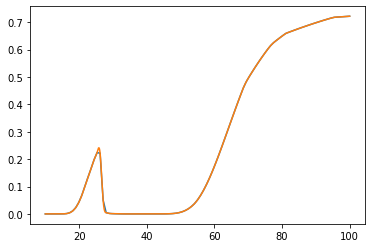

In [33]:
plt.plot(Zr[Zr.columns[0]], Zr[Zr.columns[1]])
plt.plot(x_new, Zr_new)

In [93]:
%matplotlib inline

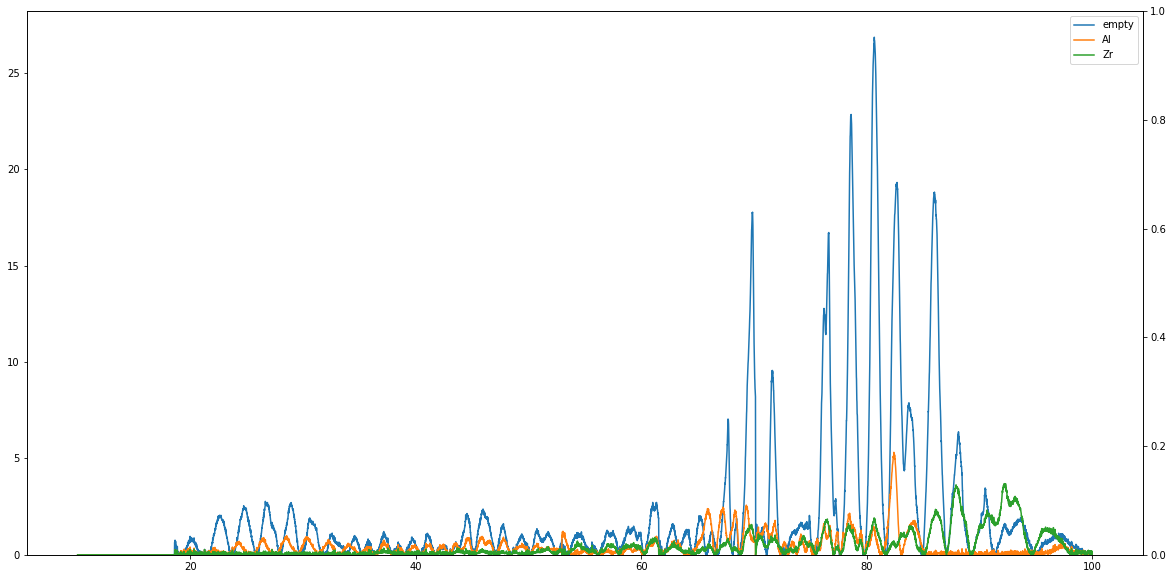

In [96]:
fig,ax = plt.subplots(1,figsize=(20,10))
ax.plot(x_new, E1800, label = 'empty')
ax.plot(x_new, Al1800, label = 'Al')
ax.plot(x_new, Zr1800, label = 'Zr')
ax.set_ylim(0)
ax2 = ax.twinx()
# ax2.plot(x_new, Zr_new, 'k:')
# ax2.plot(x_new, Al_new,'r--')
ax2.set_ylim(0)
ax.legend()
plt.show()

Now we have different things to look at:
1 - high energy when Zr is transmitting
2- low energy when Al is not

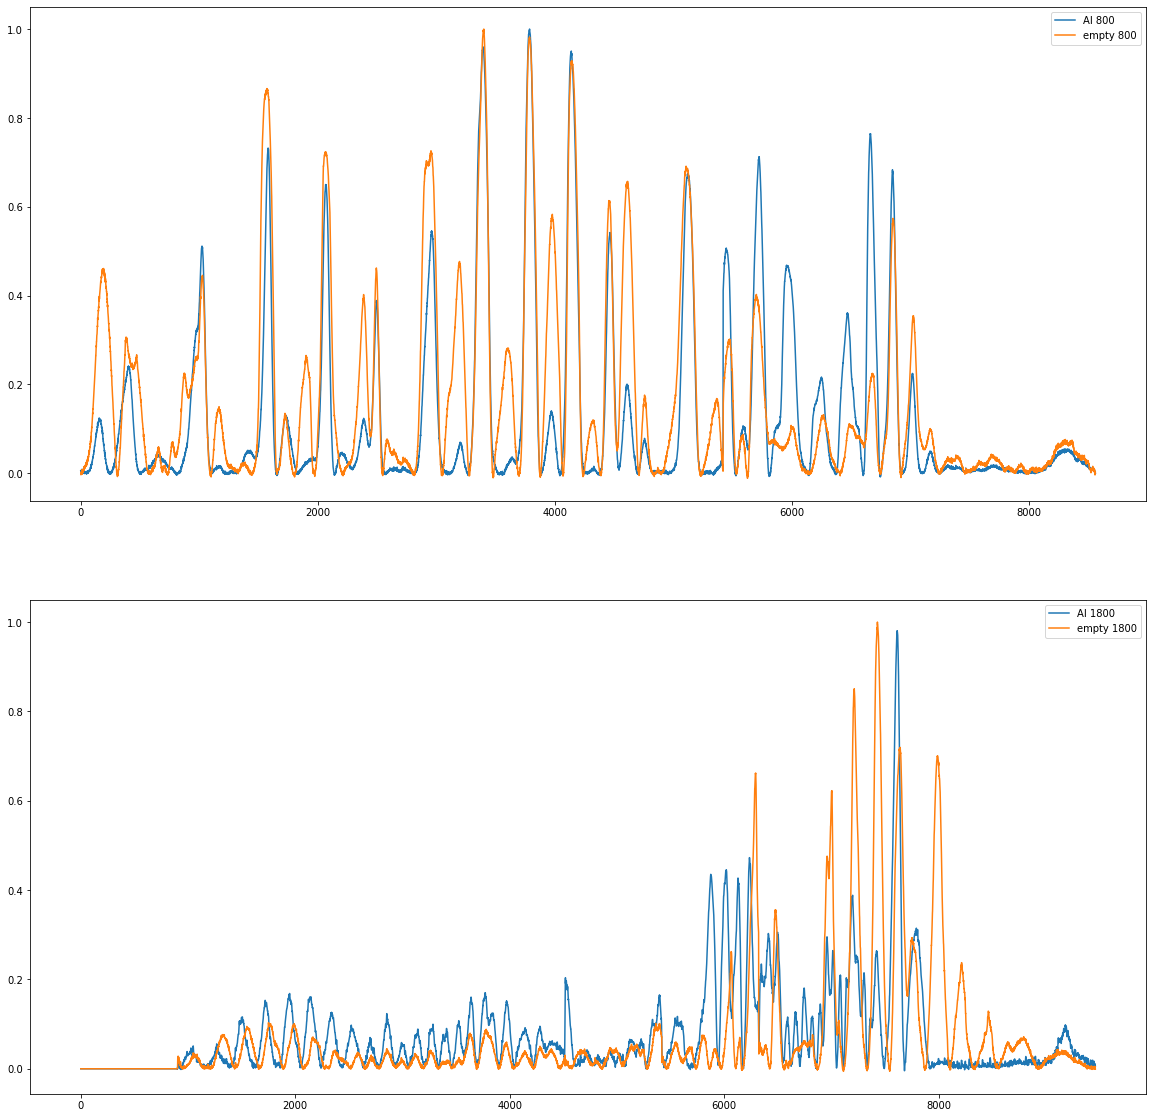

In [75]:
fig, ax = plt.subplots(2, figsize = (20,20))

ax[0].plot(Al800/max(Al800), label = 'Al 800')
ax[1].plot(savgol_filter(Al1800/max(Al1800),11,3), label = 'Al 1800')
ax[0].plot(E800/max(E800), label = 'empty 800')
ax[0].legend()
ax[1].plot(E1800/max(E1800), label = 'empty 1800')
ax[1].legend()

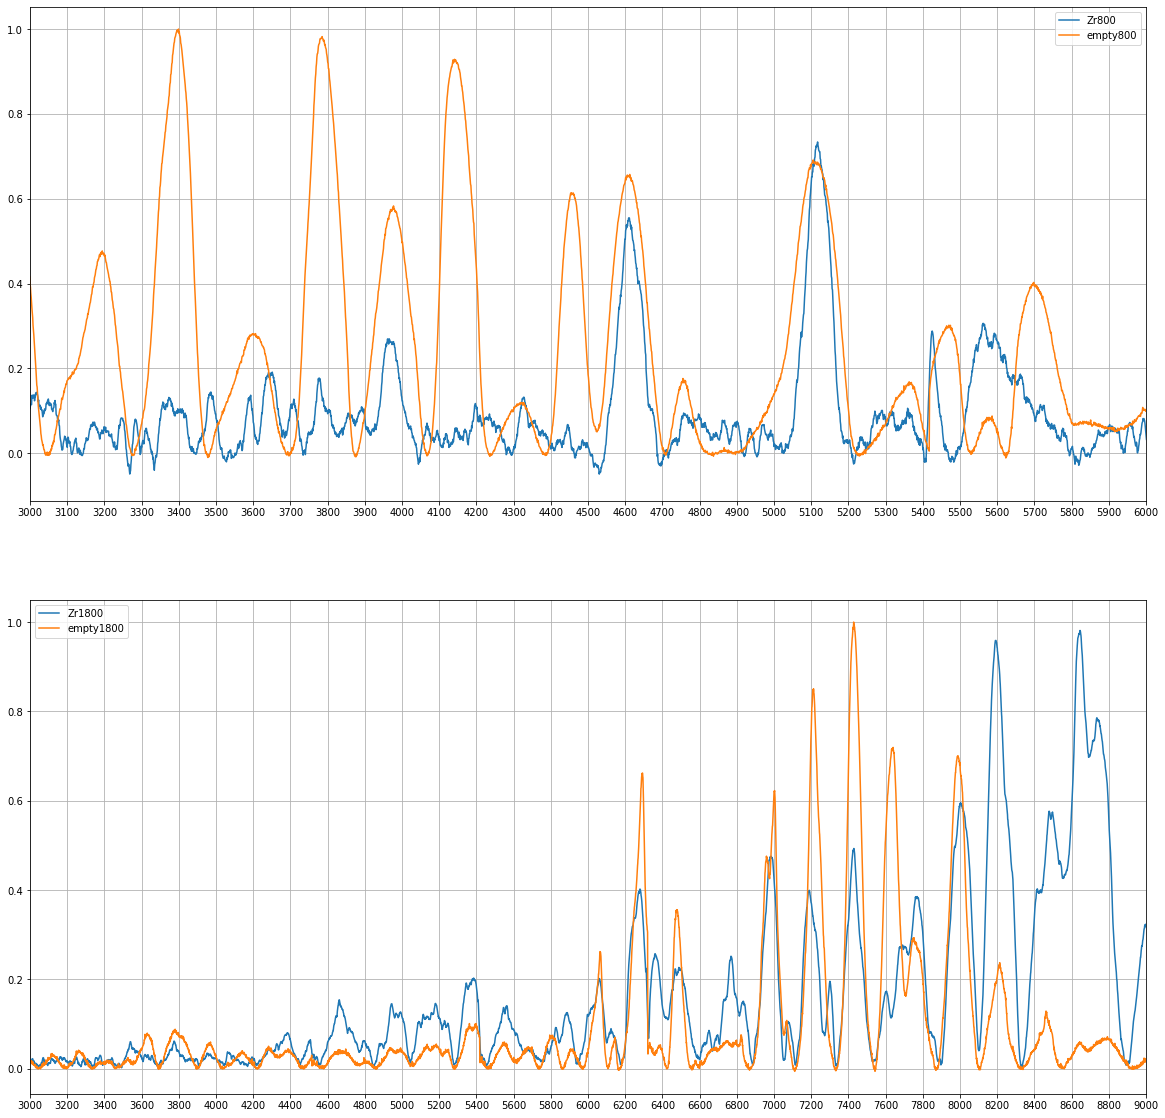

In [87]:
fig, ax = plt.subplots(2, figsize = (20,20))

ax[0].plot(savgol_filter(Zr800/max(Zr800), 31,3)-0.1, label = 'Zr800')
ax[1].plot(savgol_filter(Zr1800/max(Zr1800), 21, 3), label = 'Zr1800')
ax[0].plot(E800/max(E800), label = 'empty800')
ax[0].legend()
ax[1].plot(E1800/max(E1800), label = 'empty1800')
ax[1].set_xticks(np.arange(0,10000,200))
ax[0].set_xticks(np.arange(0,10000,100))
ax[1].grid()
ax[0].grid()
ax[1].set_xlim(3000,9000)
ax[0].set_xlim(3000,6000)
ax[1].legend()

# Grating Equation

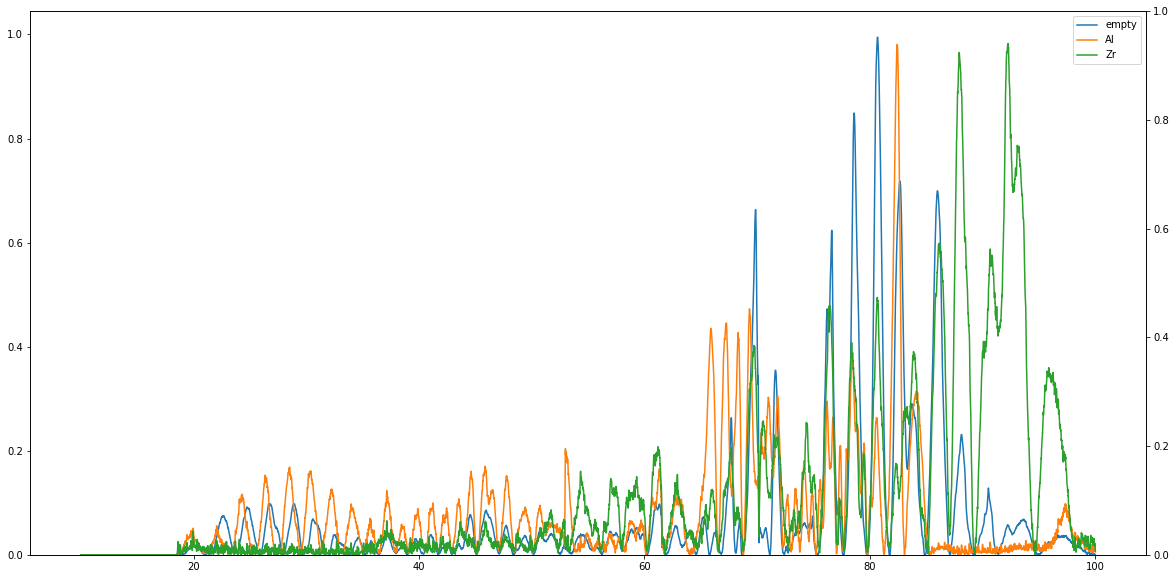

In [98]:
fig,ax = plt.subplots(1,figsize=(20,10))
ax.plot(x_new, savgol_filter(E1800/max(E1800), 11, 3), label = 'empty')
ax.plot(x_new, savgol_filter(Al1800/max(Al1800), 11, 3), label = 'Al')
ax.plot(x_new, savgol_filter(Zr1800/max(Zr1800), 11, 3), label = 'Zr')
ax.set_ylim(0)
ax2 = ax.twinx()
# ax2.plot(x_new, Zr_new, 'k:')
# ax2.plot(x_new, Al_new,'r--')
ax2.set_ylim(0)
ax.legend()
plt.show()

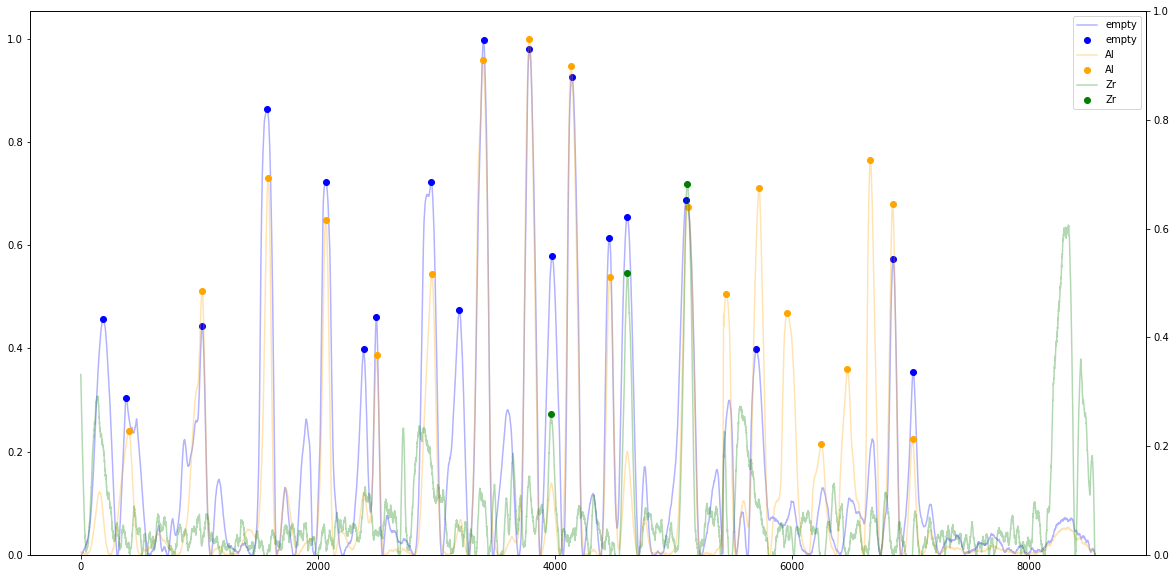

In [24]:
fig,ax = plt.subplots(1,figsize=(20,10))
peaksE, _ = find_peaks(savgol_filter(E800/max(E800), 11, 3), height = 0.3, distance=100)
peaksAl, _ = find_peaks(savgol_filter(Al800/max(Al800), 11, 3), height = 0.2, distance=100)
peaksZr, _ = find_peaks(savgol_filter(Zr800/max(Zr800), 51, 3)-0.1, height = 0.2, distance=20)
peaksZr = peaksZr[(peaksZr>3000)*(peaksZr<5300)]
ax.plot(savgol_filter(E800/max(E800), 11, 3), label = 'empty',color='blue', alpha=0.3)
ax.plot(peaksE,savgol_filter(E800/max(E800), 11, 3)[peaksE],'o',color='blue', label = 'empty')
ax.plot(savgol_filter(Al800/max(Al800), 11, 3), label = 'Al',color='orange', alpha=0.3)
ax.plot(peaksAl,savgol_filter(Al800/max(Al800), 11, 3)[peaksAl],'o',color='orange', label = 'Al')
ax.plot(savgol_filter(Zr800/max(Zr800), 51, 3)-0.1, label = 'Zr', color='green', alpha=0.3)
ax.plot(peaksZr,(savgol_filter(Zr800/max(Zr800), 51, 3)-0.1)[peaksZr],'o', color='green', label = 'Zr')
ax.set_ylim(0)
ax2 = ax.twinx()
# ax2.plot(x_new, Zr_new, 'k:')
# ax2.plot(x_new, Al_new,'r--')
ax2.set_ylim(0)
ax.legend()
plt.show()

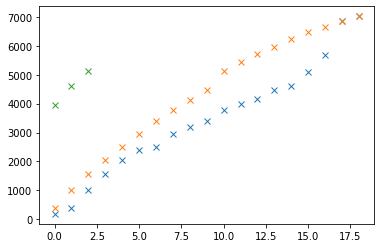

In [25]:

plt.plot(peaksE, 'x')
plt.plot(peaksAl, 'x')
plt.plot(peaksZr,'x')

In [26]:
peak = []
for e in peaksE:
    for a in peaksAl:
        if a in np.arange(e-50, e+50):
            peak.append(a)

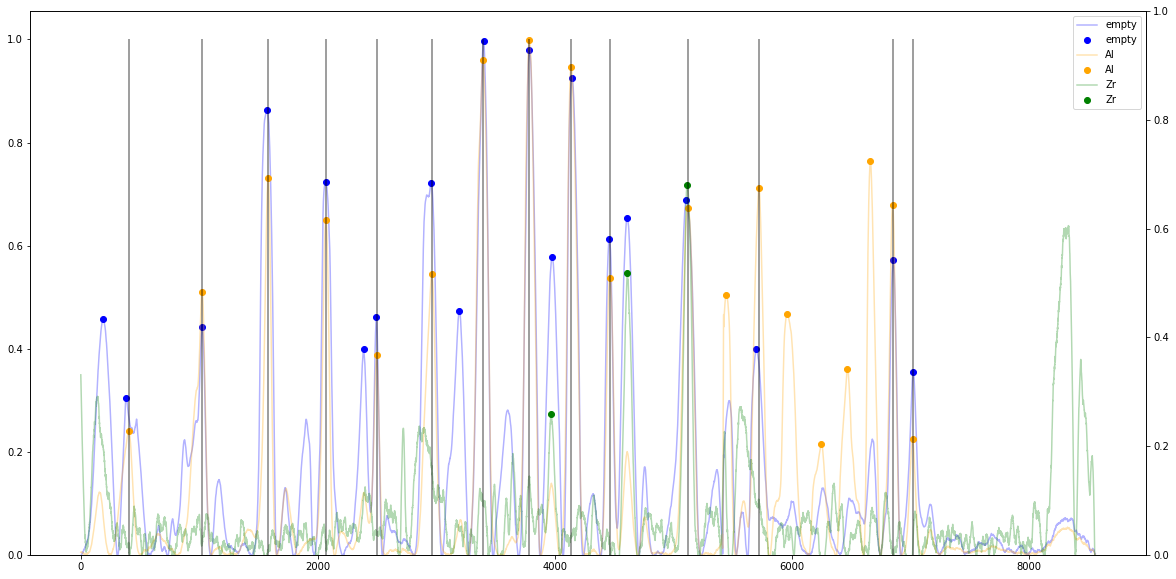

In [27]:
fig,ax = plt.subplots(1,figsize=(20,10))
ax.plot(savgol_filter(E800/max(E800), 11, 3), label = 'empty',color='blue', alpha=0.3)
ax.plot(peaksE,savgol_filter(E800/max(E800), 11, 3)[peaksE],'o',color='blue', label = 'empty')
ax.plot(savgol_filter(Al800/max(Al800), 11, 3), label = 'Al',color='orange', alpha=0.3)
ax.plot(peaksAl,savgol_filter(Al800/max(Al800), 11, 3)[peaksAl],'o',color='orange', label = 'Al')
ax.plot(savgol_filter(Zr800/max(Zr800), 51, 3)-0.1, label = 'Zr', color='green', alpha=0.3)
ax.plot(peaksZr,(savgol_filter(Zr800/max(Zr800), 51, 3)-0.1)[peaksZr],'o', color='green', label = 'Zr')

ax.vlines(peak, ymin=0, ymax=1, alpha=0.5, color='black')
ax.set_ylim(0)
ax2 = ax.twinx()
# ax2.plot(x_new, Zr_new, 'k:')
# ax2.plot(x_new, Al_new,'r--')
ax2.set_ylim(0)
ax.legend()
plt.show()

In [28]:
peak_filled = peak.copy()
peak_filled.append(4800)
peak_filled.append(5956)
peak_filled.append(6246)
peak_filled.append(6466)
peak_filled.sort()

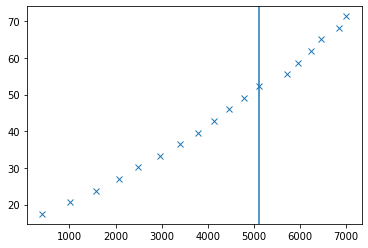

In [29]:
har800 = (1240/782)*np.arange(1, 101, 2)
i=5
plt.axvline(5120)
plt.plot(peak_filled, har800[i:i+len(peak_filled)],'x')

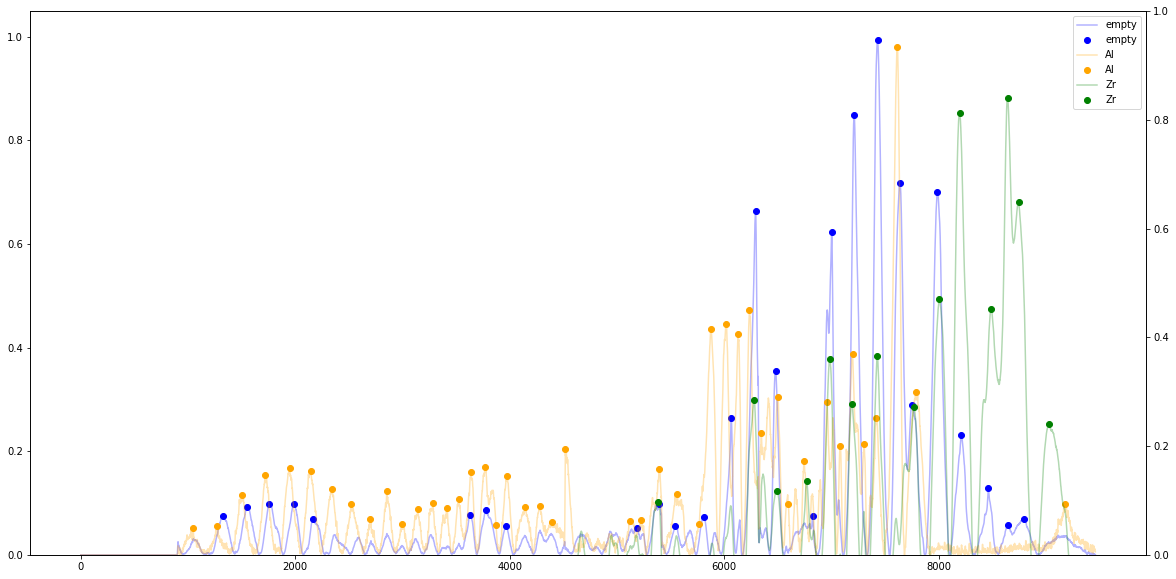

In [30]:
fig,ax = plt.subplots(1,figsize=(20,10))
peaksE1, _ = find_peaks(savgol_filter(E1800/max(E1800), 11, 3), height = 0.05, distance=100)
peaksAl1, _ = find_peaks(savgol_filter(Al1800/max(Al1800), 11, 3), height = 0.05, distance=100)
peaksZr1, _ = find_peaks(savgol_filter(Zr1800/max(Zr1800), 51, 3)-0.1, height = 0.1, distance=100)

ax.plot(savgol_filter(E1800/max(E1800), 11, 3), label = 'empty',color='blue', alpha=0.3)
ax.plot(peaksE1,savgol_filter(E1800/max(E1800), 11, 3)[peaksE1],'o',color='blue', label = 'empty')
ax.plot(savgol_filter(Al1800/max(Al1800), 11, 3), label = 'Al',color='orange', alpha=0.3)
ax.plot(peaksAl1,savgol_filter(Al1800/max(Al1800), 11, 3)[peaksAl1],'o',color='orange', label = 'Al')
ax.plot(savgol_filter(Zr1800/max(Zr1800), 51, 3)-0.1, label = 'Zr', color='green', alpha=0.3)
ax.plot(peaksZr1,(savgol_filter(Zr1800/max(Zr1800), 51, 3)-0.1)[peaksZr1],'o', color='green', label = 'Zr')
ax.set_ylim(0)
ax2 = ax.twinx()
# ax2.plot(x_new, Zr_new, 'k:')
# ax2.plot(x_new, Al_new,'r--')
ax2.set_ylim(0)
ax.legend()
plt.show()

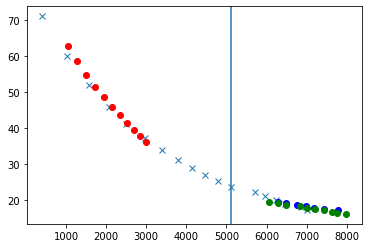

In [31]:
har1800 = (1240/1700)*np.arange(1, 151, 2)
har800 = (1240/782)*np.arange(1, 101, 2)
i=5
plt.axvline(5120)
plt.plot(peak_filled, 1240/(har800[i:i+len(peak_filled)]),'x')
plt.plot(peaksAl1[peaksAl1<3000],1240/(har1800[(har1800>19)*(har1800<35)]), 'ro')
plt.plot(peaksZr1[(peaksZr1>6000)*(peaksZr1<8000)],1240/(har1800[(har1800>63)*(har1800<73)]), 'bo')
plt.plot(peaksE1[(peaksE1>6000)*(peaksE1<8000)],1240/(har1800[(har1800>63)*(har1800<78)]), 'go')

In [32]:
def grating(pxl, P0, X0, Gamma):
    alpha = 87
    g = 1200
    m = 1
    L = 253
    Pdet = P0+pxl
    Xdet = X0 - Gamma*Pdet
    beta = 90 - np.rad2deg(np.arctan((Xdet)/(L+Xdet)))
    lam = (np.sin(np.deg2rad(alpha)) - np.sin(np.deg2rad(beta)))/(m*g)    
    return lam

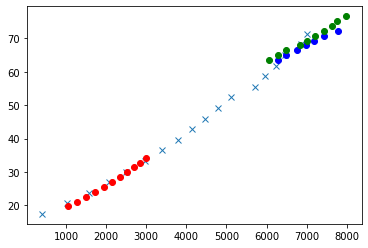

In [33]:
plt.plot(peak_filled, (har800[i:i+len(peak_filled)]),'x')
plt.plot(peaksAl1[peaksAl1<3000],(har1800[(har1800>19)*(har1800<35)]), 'ro')
plt.plot(peaksZr1[(peaksZr1>6000)*(peaksZr1<8000)],(har1800[(har1800>63)*(har1800<73)]), 'bo')
plt.plot(peaksE1[(peaksE1>6000)*(peaksE1<8000)],(har1800[(har1800>63)*(har1800<78)]), 'go')

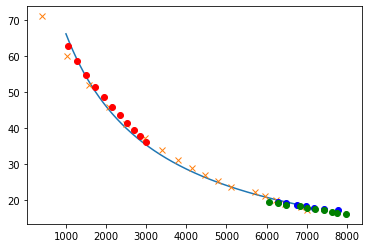

In [34]:
def fun(x,a,b):
    return (a*x+b)
par, cov = curve_fit(fun, peak_filled, (har800[i:i+len(peak_filled)]))
plt.plot(np.arange(1000,7000), 1240/fun(np.arange(1000,7000), *par))
plt.plot(peak_filled, 1240/(har800[i:i+len(peak_filled)]),'x')
plt.plot(peaksAl1[peaksAl1<3000],1240/(har1800[(har1800>19)*(har1800<35)]), 'ro')
plt.plot(peaksZr1[(peaksZr1>6000)*(peaksZr1<8000)],1240/(har1800[(har1800>63)*(har1800<73)]), 'bo')
plt.plot(peaksE1[(peaksE1>6000)*(peaksE1<8000)],1240/(har1800[(har1800>63)*(har1800<78)]), 'go')

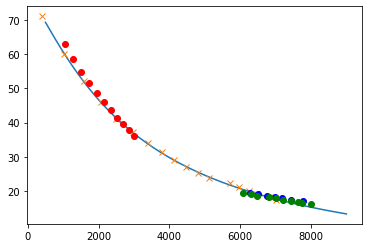

In [42]:
def fun(x,b, c,a,d):
    return (c/(x**d+b))+a
par, cov = curve_fit(fun, peak_filled, 1240/(har800[i:i+len(peak_filled)]), p0 = (-1.02676025e+08/-5.14189845e+04,1.77503051e+05,0,1))
plt.plot(np.arange(500,9000), fun(np.arange(500,9000), *par))
plt.plot(peak_filled, 1240/(har800[i:i+len(peak_filled)]),'x')
plt.plot(peaksAl1[peaksAl1<3000],1240/(har1800[(har1800>19)*(har1800<35)]), 'ro')
plt.plot(peaksZr1[(peaksZr1>6000)*(peaksZr1<8000)],1240/(har1800[(har1800>63)*(har1800<73)]), 'bo')
plt.plot(peaksE1[(peaksE1>6000)*(peaksE1<8000)],1240/(har1800[(har1800>63)*(har1800<78)]), 'go')

In [44]:
har800[i:i+len(peak_filled)]

array([17.44245524, 20.61381074, 23.78516624, 26.95652174, 30.12787724,
       33.29923274, 36.47058824, 39.64194373, 42.81329923, 45.98465473,
       49.15601023, 52.32736573, 55.49872123, 58.67007673, 61.84143223,
       65.01278772, 68.18414322, 71.35549872])

In [ ]:
def calib(pxl, height)

# PCA for bg

In [389]:
from sklearn.decomposition import PCA
%matplotlib inline

In [397]:
X = np.zeros((len(df), len(df.keys()[0])))

In [552]:
def sub_bg(arr):
    arr_new = arr - df[53]
    arr_new[arr_new<0]=0
    return arr_new
    

In [553]:
y = np.stack(df)
y = np.apply_along_axis(sub_bg, axis = 1, arr=y)
y.shape

(55, 5468)

In [554]:
for i in range(len(df.keys())):
    k = df.keys()[i]
    wl = ''.join(filter(str.isdigit, k[0]))
    if len(wl) == 0:
        wl = -1
    fl = ''.join(filter(str.isdigit, k[1]))
    gas = ''.join(filter(str.isdigit, k[2]))
    if len(gas) == 0:
        gas = -1
    mcp = ''.join(filter(str.isdigit, k[3]))
    t = ''.join(filter(str.isdigit, k[4]))
    h = ''.join(filter(str.isdigit, k[5]))
    X[i] = [int(wl),int(fl),int(gas),int(mcp), int(t),int(h)]
    

In [555]:
pca.components_.shape

(35, 5468)

In [589]:
features = 35
pca = PCA(n_components=features)
p = pca.fit_transform(y)
revers = np.dot(p[:, :features], pca.components_[:features, :])
revers = revers + np.mean(y, axis=0)

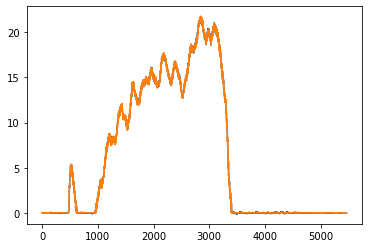

In [595]:
num = 10
plt.plot(revers[num])
plt.plot(y[num])

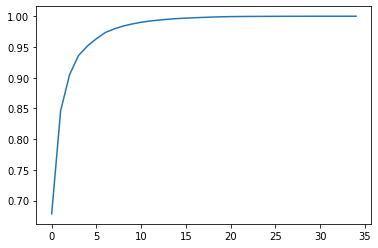

In [558]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [559]:
corr = np.zeros((6,features))
for j in range(6):
    for i in range(features):
        corr[j,i] = pearsonr(X[:,j], p[:,i])[0]

/Users/kasia/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


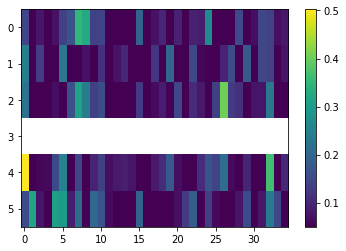

In [560]:
plt.imshow(abs(corr), aspect = 'auto', vmin=0.05)
plt.colorbar()

(array([11.,  8.,  4.,  3.,  1.,  2.,  3.,  1.,  1.,  1.]),
 array([0.00100495, 0.05677899, 0.11255302, 0.16832706, 0.22410109,
        0.27987513, 0.33564917, 0.3914232 , 0.44719724, 0.50297127,
        0.55874531]),
 <BarContainer object of 10 artists>)

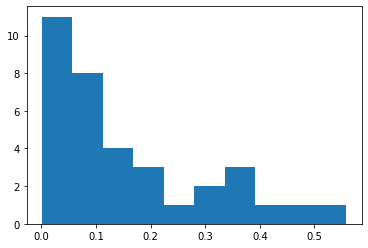

In [561]:
plt.hist(abs(np.nansum(corr, axis=0)))

In [604]:
check = np.nansum(abs(corr), axis=0)
check.sort()
check

array([0.10776453, 0.14660097, 0.17353328, 0.20112474, 0.21388425,
       0.21836115, 0.22593987, 0.26630213, 0.3103544 , 0.31257783,
       0.33098739, 0.35266791, 0.35664908, 0.35714067, 0.36913083,
       0.36960644, 0.39696653, 0.40291875, 0.42332097, 0.46898386,
       0.47973296, 0.49191931, 0.50442065, 0.55252806, 0.57461521,
       0.60947958, 0.62505398, 0.65493826, 0.69525628, 0.71362623,
       0.73688413, 0.91686717, 1.01821467, 1.11026886, 1.26326355])

In [623]:
mask_clean = np.nansum(abs(corr), axis=0)>0.3
sum(mask_clean)

27

In [624]:
revers_clean = np.dot(p[:, mask_clean], pca.components_[mask_clean, :])
revers_clean = revers_clean + np.mean(y, axis=0)

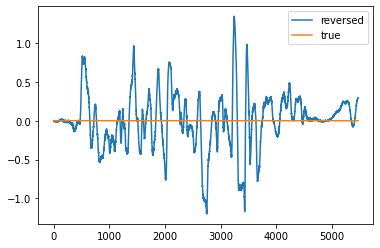

In [649]:
num = np.random.randint(0,35)
plt.plot(revers_clean[num], label = 'reversed')
plt.plot(y[num], label = 'true')
#plt.plot(y[31], label = 'bg')
plt.plot()
plt.legend()

In [614]:
for i in range(len(df)):
    print(i, df.keys()[i])

0 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '1000ms', '0')
1 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '1')
2 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '3')
3 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '5')
4 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '6')
5 ('1800nm', '0empty', 'Argon300mbar', 'MCP1650V', '2000ms', '7')
6 ('1800nm', '120Al', 'Argon300mbar', 'MCP1650V', '2000ms', '7')
7 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '1')
8 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '3')
9 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '5')
10 ('1800nm', '120Zr', 'Argon300mbar', 'MCP1650V', '2000ms', '6')
11 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '1')
12 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '3')
13 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '5')
14 ('1800nm', '240Al', 'Argon300mbar', 'MCP1650V', '2000ms', '6')
15 ('1800nm', 